In [1]:
import os.path
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Resize, ToTensor, Compose, Normalize
from tqdm import tqdm
import numpy as np
import shutil
import matplotlib.pyplot as plt
import glob
from pprint import pprint
from PIL import Image
import cv2
import torch.optim as optim
from sklearn.metrics import accuracy_score

In [2]:
data_path = "/kaggle/input/cub2002011/CUB_200_2011"

**<p style="color: cyan; font-size : 30pt">Load Data</p>**

In [3]:
def load_txt(paths, cols):
    df = pd.read_csv(paths, sep=" ", header=None)
    df.columns = cols
    return df

In [4]:
bounding_box_df = load_txt('/kaggle/input/cub2002011/CUB_200_2011/bounding_boxes.txt', ['id','x','y','width','height'])
image_class = load_txt('{}/image_class_labels.txt'.format(data_path), ['id', 'class'])
image_name = load_txt('{}/images.txt'.format(data_path), ['id','image_name'])
train_test_split = load_txt('{}/train_test_split.txt'.format(data_path),['id','split'])

In [5]:
data = bounding_box_df
data = data.merge(image_class, how='inner')
data = data.merge(image_name, how='inner')
data = data.merge(train_test_split, how='inner')

In [6]:
pprint(data.head(2))

   id      x     y  width  height  class  \
0   1   60.0  27.0  325.0   304.0      1   
1   2  139.0  30.0  153.0   264.0      1   

                                          image_name  split  
0  001.Black_footed_Albatross/Black_Footed_Albatr...      0  
1  001.Black_footed_Albatross/Black_Footed_Albatr...      1  


In [7]:
transforms = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406],  
              std=[0.229, 0.224, 0.225])
])

**<p style="color: cyan; font-size : 30pt">Draw Bounding Box</p>**

In [8]:
data_visualize = data.iloc[0]
pprint(data_visualize)
image_path = '{}/images/{}'.format(data_path, data_visualize['image_name'])

id                                                            1
x                                                          60.0
y                                                          27.0
width                                                     325.0
height                                                    304.0
class                                                         1
image_name    001.Black_footed_Albatross/Black_Footed_Albatr...
split                                                         0
Name: 0, dtype: object


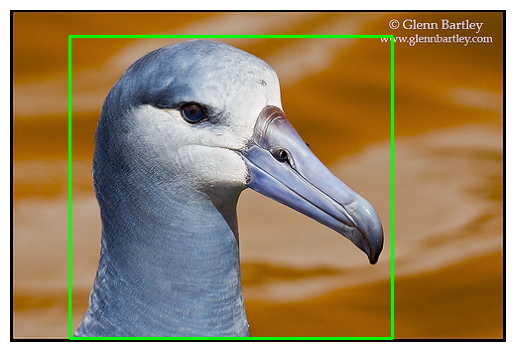

In [9]:
image = Image.open(image_path).convert("RGB")
image = np.array(image)

x_min, y_min = int(data_visualize['x']), int(data_visualize['y'])
width, height = int(data_visualize['width']), int(data_visualize['height'])
color = (0, 255, 0)
cv2.rectangle(image, (x_min, y_min), (x_min + width, y_min + height), color, 2)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


**<p style="color: cyan; font-size : 30pt">Dataset</p>**

In [10]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transforms):
        self.dataframe = dataframe
        self.transforms = transforms
        self.image_dir = '/kaggle/input/cub2002011/CUB_200_2011/images'
        
    def __len__(self):
        return self.dataframe.shape[0]
    
    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        image_path = os.path.join(self.image_dir, row['image_name'])

        image = Image.open(image_path).convert('RGB')
        width, height = image.size
        image = self.transforms(image)
        
        x, y, w, h = row['x'], row['y'], row['width'], row['height']
        x_center, y_center = x + w / 2, y + h / 2
        bbox = [x_center / width, y_center / height, w / width, h / height]

        cls = torch.tensor(row['class'] - 1, dtype=torch.long)

        return {
            "image": image.type(torch.float32),
            "bbox": torch.tensor(bbox, dtype=torch.float32),  
            "cls": cls  
        }

In [11]:
train_ds = CustomDataset(data[data['split'] == 1], transforms)  
val_ds = CustomDataset(data[data['split'] == 0], transforms) 

batch_size = 16

train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count(), prefetch_factor=2)
val_dataloader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count(), prefetch_factor=2)

for batch in train_dataloader:
    image = batch['image']  
    bbox = batch['bbox'] 
    cls = batch['cls']  
    
    print("Shape of image batch:", image.shape)  
    print("Shape of bbox batch:", bbox.shape) 
    print("Shape of cls batch:", cls.shape)  
    
    break

Shape of image batch: torch.Size([16, 3, 224, 224])
Shape of bbox batch: torch.Size([16, 4])
Shape of cls batch: torch.Size([16])


**<p style="color: cyan; font-size : 30pt">MyModel</p>**

In [12]:
class ImprovedResNetCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(ImprovedResNetCNN, self).__init__()
        
        resnet = models.resnet18(pretrained=True)
        
        self.resnet_backbone = nn.Sequential(*list(resnet.children())[:-1])
        
        for param in self.resnet_backbone.parameters():
            param.requires_grad = False
        
        self.fc1 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=512, out_features=2048), 
            nn.ReLU()
        )
        
        self.fc2 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=2048, out_features=1024),
            nn.ReLU()
        )
        
        self.classifier = nn.Linear(in_features=1024, out_features=num_classes)
        
        self.regressor = nn.Linear(in_features=1024, out_features=4)  
    
    def forward(self, x):
        x = self.resnet_backbone(x)
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.fc2(x)

        classification_output = self.classifier(x)
        bbox_output = self.regressor(x)
        
        return classification_output, bbox_output


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
model = ImprovedResNetCNN(num_classes= 200)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 157MB/s] 


In [ ]:
model.to(torch.float32)

In [ ]:
model.to("cuda")

**<p style="color: cyan; font-size : 30pt">Train</p>**

In [17]:
image_size = 224 
batch_size = 16
epochs = 20
lr = 0.01

In [18]:
criterion_cls = nn.CrossEntropyLoss()  
criterion_mse = nn.MSELoss()  

checkpoint_path = '/kaggle/working/checkpoints'
os.makedirs(checkpoint_path, exist_ok=True)

def train():
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    best_acc = -100 

    for epoch in range(epochs):
        model.train()
        progress_bar = tqdm(train_dataloader, colour="cyan")
        for i, batch in enumerate(progress_bar):
            images = batch['image'].to(device)  
            bbox = batch['bbox'].to(device) 
            cls = batch['cls'].to(device)  

            output_cls, bbox_pred = model(images)

            loss_cls = criterion_cls(output_cls, cls)
            loss_bbox = criterion_mse(bbox_pred, bbox)

            total_loss = 0.5 * loss_cls + 0.5 * loss_bbox

            progress_bar.set_description(f"Epoch {epoch+1}/{epochs}. Loss: {total_loss.item():.4f}")

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

        model.eval()
        all_losses = []
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for batch in tqdm(val_dataloader, colour = "red"):
                images = batch['image'].to(device) 
                bbox = batch['bbox'].to(device) 
                cls = batch['cls'].to(device)  

                output_cls, bbox_pred = model(images)

                loss_cls = criterion_cls(output_cls, cls)
                loss_bbox = criterion_mse(bbox_pred, bbox)

                total_loss = 0.5 * loss_cls + 0.5 * loss_bbox
                predictions = torch.argmax(output_cls, dim=1)

                all_losses.append(total_loss.item())
                all_labels.extend(cls.tolist())
                all_predictions.extend(predictions.tolist())

            loss = np.mean(all_losses)
            accuracy = accuracy_score(all_labels, all_predictions)

            print(f"Epoch {epoch+1}/{epochs}. Loss: {loss:.4f}. Acc: {accuracy:.4f}")

            checkpoint = {
                "model_state_dict": model.state_dict(),
                "epoch": epoch,
                "optimizer_state_dict": optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join(checkpoint_path, "last.pt"))

            if accuracy > best_acc:
                torch.save(checkpoint, os.path.join(checkpoint_path, "best.pt"))
                best_acc = accuracy

In [19]:
train()

100%|██████████| 363/363 [00:27<00:00, 13.30it/s]


Epoch 1/20. Loss: 2.6586. Acc: 0.0185


100%|██████████| 363/363 [00:18<00:00, 19.25it/s]


Epoch 2/20. Loss: 2.6381. Acc: 0.0518


100%|██████████| 363/363 [00:18<00:00, 19.20it/s]


Epoch 3/20. Loss: 2.6062. Acc: 0.0753


100%|██████████| 363/363 [00:17<00:00, 21.06it/s]


Epoch 4/20. Loss: 2.5492. Acc: 0.1091


100%|██████████| 363/363 [00:18<00:00, 19.88it/s]


Epoch 5/20. Loss: 2.4599. Acc: 0.1307


100%|██████████| 363/363 [00:16<00:00, 21.63it/s]


Epoch 6/20. Loss: 2.3300. Acc: 0.1117


100%|██████████| 363/363 [00:18<00:00, 19.93it/s]


Epoch 7/20. Loss: 2.1942. Acc: 0.1400


100%|██████████| 363/363 [00:17<00:00, 20.46it/s]


Epoch 8/20. Loss: 2.0594. Acc: 0.1503


100%|██████████| 363/363 [00:17<00:00, 21.01it/s]


Epoch 9/20. Loss: 1.9709. Acc: 0.1902


100%|██████████| 363/363 [00:17<00:00, 20.96it/s]


Epoch 10/20. Loss: 1.8003. Acc: 0.2028


100%|██████████| 363/363 [00:17<00:00, 20.68it/s]


Epoch 11/20. Loss: 1.6748. Acc: 0.2660


100%|██████████| 363/363 [00:16<00:00, 21.56it/s]


Epoch 12/20. Loss: 1.6337. Acc: 0.2879


100%|██████████| 363/363 [00:16<00:00, 21.41it/s]


Epoch 13/20. Loss: 1.4988. Acc: 0.3208


100%|██████████| 363/363 [00:16<00:00, 21.72it/s]


Epoch 14/20. Loss: 1.4524. Acc: 0.3391


100%|██████████| 363/363 [00:16<00:00, 21.58it/s]


Epoch 15/20. Loss: 1.3543. Acc: 0.3637


100%|██████████| 363/363 [00:16<00:00, 21.55it/s]


Epoch 16/20. Loss: 1.3054. Acc: 0.3757


100%|██████████| 363/363 [00:17<00:00, 20.90it/s]


Epoch 17/20. Loss: 1.2707. Acc: 0.3911


100%|██████████| 363/363 [00:17<00:00, 20.71it/s]


Epoch 18/20. Loss: 1.2491. Acc: 0.4078


100%|██████████| 363/363 [00:19<00:00, 18.56it/s]


Epoch 19/20. Loss: 1.1962. Acc: 0.4218


100%|██████████| 363/363 [00:17<00:00, 20.98it/s]


Epoch 20/20. Loss: 1.1648. Acc: 0.4125


**<p style="color: cyan; font-size : 30pt">Inference</p>**

Predicted class: 0
Bounding box : tensor([[0.4947, 0.4228, 0.2855, 0.3349]], device='cuda:0')


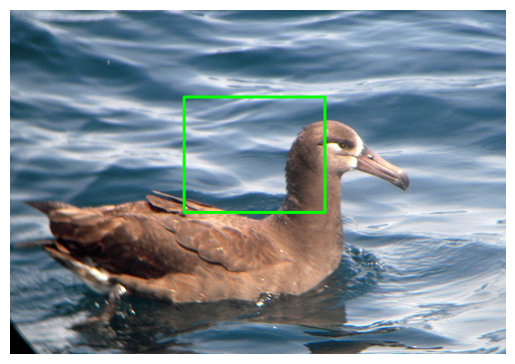

In [20]:
checkpoint = torch.load('/kaggle/working/checkpoints/best.pt', map_location=device, weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

image_path = '/kaggle/input/cub2002011/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0002_55.jpg'
image = Image.open(image_path)
image_width, image_height = image.size

input_image = transforms(image).unsqueeze(0).to(device)

with torch.no_grad():
    output_cls, bbox_pred = model(input_image)

predictions = torch.argmax(output_cls, dim=1)
print(f"Predicted class: {predictions.item()}")
print(f"Bounding box : {bbox_pred}")
x_center, y_center, width, height = bbox_pred[0][0].item(), bbox_pred[0][1].item(), bbox_pred[0][2].item(), bbox_pred[0][3].item()

x_min = int((x_center - width / 2) * image_width)
y_min = int((y_center - height / 2) * image_height)
box_width = int(width * image_width)
box_height = int(height * image_height)

color = (0, 255, 0)  
thickness = 2 
input_image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR) 
cv2.rectangle(input_image_cv, (x_min, y_min), (x_min + box_width, y_min + box_height), color, thickness)

plt.imshow(cv2.cvtColor(input_image_cv, cv2.COLOR_BGR2RGB))  
plt.axis('off')
plt.show()
